In [50]:
from numpy import *
from numpy import random
from numba import jit
import matplotlib.pyplot as plt


#### Randomize lattice and calculate energy
$H = -\sum_{<r, r'>} S_r S_{r'}$

In [51]:
@jit(nopython=True)
def CEnergy(latt):
    N = shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]  
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    return array(sign(2*random.random((N,N))-1),dtype=int) 

#### Energy range $[-2N^2, -2N^2 + 4, ..., 2N^2]$

In [52]:
def PrepareEnergies(N):
    Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist()
    Energies.pop(1)  
    Energies.pop(-2) 
    Energies = array(Energies) 
    Emin, Emax = Energies[0],Energies[-1]
    
    indE = -ones(Emax+1-Emin, dtype=int)
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    return (Energies, indE, Emin)

#### Wang Landau

In [53]:
from numpy import random
def WangLandau(Nitt, N, flatness):
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    (lngE, Hist) = RunWangLandau(Nitt,Energies,latt,indE)
    return (Energies,lngE, Hist)

@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) 
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (lngE, Hist)

In [54]:
from numpy import random

flatness = 0.9
N = 4
Nitt = int(10e8)

(Energies, lngE, Hist) = WangLandau(Nitt, N, flatness)
print('Done')

1999 histogram is flat 119.0 125.0 f= 1.6487212707001282
4999 histogram is flat 189.0 187.5 f= 1.2840254166877414
6999 histogram is flat 118.0 125.0 f= 1.1331484530668263
8999 histogram is flat 116.0 125.0 f= 1.0644944589178593
11999 histogram is flat 173.0 187.5 f= 1.0317434074991028
15999 histogram is flat 232.0 250.0 f= 1.0157477085866857
23999 histogram is flat 470.0 500.0 f= 1.007843097206448
33999 histogram is flat 592.0 625.0 f= 1.0039138893383475
44999 histogram is flat 668.0 687.5 f= 1.0019550335910028
58999 histogram is flat 795.0 875.0 f= 1.0009770394924165
82999 histogram is flat 1390.0 1500.0 f= 1.0004884004786945
107999 histogram is flat 1407.0 1562.5 f= 1.0002441704297478
161999 histogram is flat 3104.0 3375.0 f= 1.0001220777633837
179999 histogram is flat 1023.0 1125.0 f= 1.0000610370189331
209999 histogram is flat 1755.0 1875.0 f= 1.000030518043791
273999 histogram is flat 3606.0 4000.0 f= 1.0000152589054785
303999 histogram is flat 1717.0 1875.0 f= 1.000007629423635
3

In [55]:
lngE[0],lngE[-1]

(np.float64(320.71325977629135), np.float64(320.86493672535426))

In [56]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1]) = 4/(g[-1]*(1+g[0]/g[-1]))
# g = g * 4/(g[-1]*(1+g[0]/g[-1]))
# log(g) = log(g) + log(4)-log(g[-1]) - log(1+g[0]/g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = log(4)-lngE[-1]-log(1+exp(lngE[0]-lngE[-1]))
else:
    lgC = log(4)-lngE[0]-log(1+exp(lngE[-1]-lngE[0]))

lngE += lgC

In [57]:
exp(lngE[0])+exp(lngE[-1]), exp(lngE[0]), exp(lngE[-1])  # g[0]+g[-1]

(np.float64(3.999999999999997),
 np.float64(1.848613172192799),
 np.float64(2.151386827807198))

[-32 -24 -20 -16 -12  -8  -4   0   4   8  12  16  20  24  32]


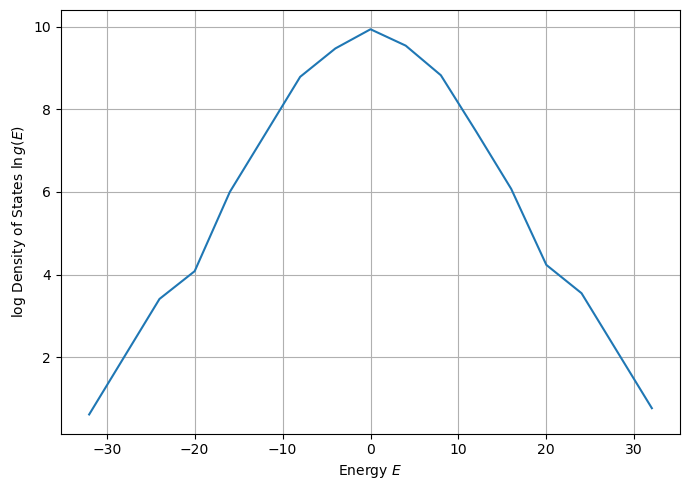

In [58]:
print(Energies)
plt.figure(figsize=(7,5))
plt.plot(Energies, lngE)
plt.xlabel("Energy $E$")
plt.ylabel("log Density of States $\\ln g(E)$")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Parition function:
$Z = \sum_{E} g[E] e^{-E/T}$

In [59]:
print(len(Energies), len(lngE))

15 15


In [63]:
print("sum(g):", sum(exp(lngE)))


sum(g): 65438.578215527086


In [60]:
import math
def partition_function(Energies, lngE, T):
    # Maximum energy
    E0 = Energies[-1]
    Z = 0

    for i, E in enumerate(Energies):
        try:
            w = float(math.exp(lngE[i] - lngE[0] - (E + E0)/T))
        except OverflowError:
            w = float('inf')
        Z += w
    return Z


Te = linspace(0.4, 8., 600)
Z = []
for T in Te:
    Z.append(partition_function(Energies, lngE,T))
Z = array(Z)

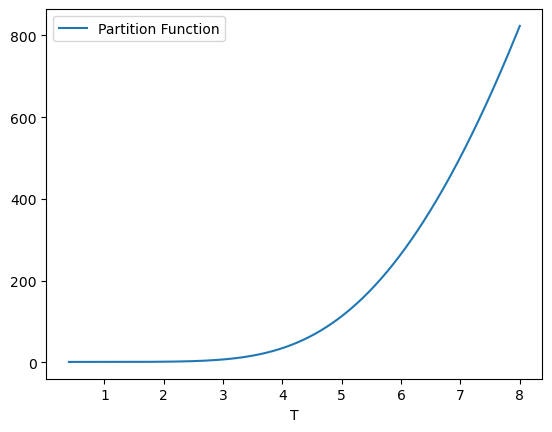

In [61]:
plt.plot(Te, Z, label='Partition Function')
plt.xlabel('T')
plt.legend(loc='best')
plt.show()

In [62]:
print(Z)

[  1.00000003   1.00000006   1.00000011   1.00000019   1.00000032
   1.00000052   1.00000083   1.00000128   1.00000194   1.00000287
   1.00000417   1.00000597   1.00000839   1.00001162   1.00001586
   1.00002137   1.00002843   1.00003738   1.00004862   1.00006258
   1.00007977   1.00010075   1.00012615   1.00015667   1.00019308
   1.00023621   1.00028698   1.00034638   1.00041548   1.00049541
   1.00058741   1.00069276   1.00081286   1.00094915   1.00110317
   1.00127653   1.00147092   1.00168808   1.00192987   1.00219817
   1.00249496   1.00282228   1.00318223   1.00357698   1.00400877
   1.00447989   1.00499268   1.00554957   1.00615302   1.00680554
   1.00750972   1.00826818   1.0090836    1.00995871   1.01089629
   1.01189917   1.01297024   1.01411242   1.01532869   1.01662208
   1.01799568   1.01945262   1.02099607   1.02262929   1.02435557
   1.02617825   1.02810076   1.03012655   1.03225918   1.03450223
   1.03685939   1.03933438   1.04193104   1.04465324   1.04750498
   1.05049